In [2]:
using Pkg 
Pkg.activate(".");

  Activating project at `~/PhD/GaussianProcessNode`


In [3]:
using Revise 
using RxInfer
using Random, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets, LaTeXStrings  
using Zygote, Optim, ForwardDiff
using KernelFunctions, MAT, LoopVectorization
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix 
import ReactiveMP: approximate_meancov, WishartFast, approximate_kernel_expectation

In [4]:
import RxInfer: PointMassFormConstraint,call_boundaries, call_starting_point

In [6]:
include("New UniSGP.jl")

## Regression

In [163]:
Random.seed!(3)
xmin, xmax = -4, 4  # Bounds of the data
N = 100# Number of samples
xtrain = sort(rand(Uniform(xmin, xmax), N))
xtest = collect(range(xmin - 0.1, xmax + 0.1; length=600));
precision = 100
ytrain = sinc.(xtrain) + randn(N) * sqrt(1/precision);
f_true = sinc.(xtest);

In [164]:
@model function gp_regression(y,x, Xu)

    v ~ MvNormalMeanCovariance(zeros(length(Xu)), 100diageye(length(Xu)))
    w ~ GammaShapeRate(1e-2,1e-2)
    θ ~ MvNormalMeanCovariance(zeros(2),50*diageye(2))
    for i in eachindex(y)
        y[i] ~ NewSGP(x[i],v,w,θ) 
    end
end

gp_constraints = @constraints begin
    q(v,w,θ) = q(v)q(w)q(θ)
    q(θ)::PointMassFormConstraint(starting_point = (args...) -> [0.,0.])
end

@meta function meta_gp_regression(Xu,kernel)
    NewSGP() -> NewSGPMeta(Xu,nothing,kernel,nothing)
end

gp_initialization = @initialization begin
    q(w) = GammaShapeRate(1e-2,1e-2)
    q(θ) = PointMass([0., 0.])
end

Initial state: 
  q(w) = GammaShapeRate{Float64}(a=0.01, b=0.01)
  q(θ) = PointMass{Vector{Float64}}([0.0, 0.0])


In [165]:
Nu = 20; #number of inducing points 

Xu = range(-4,4;length=Nu);
mean_gp = (x) -> 0
kernel_gp(θ) = exp(θ[1]) * with_lengthscale(SEKernel(),exp(θ[2]))

kernel_gp (generic function with 1 method)

In [125]:
function RxInfer.default_point_mass_form_constraint_optimizer(::Type{Multivariate}, ::Type{Continuous}, constraint::PointMassFormConstraint, distribution)
    init_val = call_starting_point(constraint, distribution)
    target = let distribution = distribution
        (x) -> -logpdf(distribution, x)  
    end
    result = optimize(target, init_val, method = Optim.AdaMax(;alpha=1e-2),iterations=50)
    return PointMass(result.minimizer)
end

struct Realsupport 
    dim
end

function Base.in(x, ::Realsupport)
    return true
end

function BayesBase.support(dist::MvNormalMeanCovariance)
    return Realsupport(length(mean(dist)))
end

In [166]:
niter = 10

infer_result = infer(
    model = gp_regression(Xu = Xu,),
    iterations = niter,
    data = (y = ytrain, x = xtrain,),
    initialization = gp_initialization,
    constraints = gp_constraints,
    meta = meta_gp_regression(Xu,kernel_gp),
    returnvars = (v = KeepLast(),w = KeepLast(),θ = KeepLast(),),
    free_energy = true,
    showprogress = false
)

Inference results:
  Posteriors       | available for (w, v, θ)
  Free Energy:     | Real[206.98, 102.215, 23.6942, -17.021, -24.4752, -24.8712, -24.88, -24.8799, -24.8799, -24.8799]


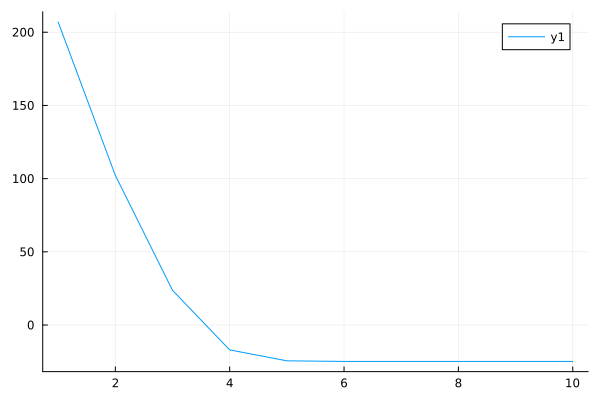

In [167]:
plot(infer_result.free_energy)

In [168]:
qv = infer_result.posteriors[:v]
qw = infer_result.posteriors[:w]
qθ = infer_result.posteriors[:θ]

PointMass{Vector{Float64}}([0.2798766853291201, -0.30320658756241586])

In [169]:
exp.(mean(qθ))

2-element Vector{Float64}:
 1.3229666610797757
 0.7384465267435971

In [159]:
##prediction
function predict_new(x_test,qv,qw,qθ, meta)
    prediction = @call_rule NewSGP(:out, Marginalisation) (q_in=PointMass(x_test),q_v = qv, q_w = qw,q_θ=qθ, meta=meta)
    return prediction
end

predict_new (generic function with 1 method)

In [170]:
predict_mean =[]
predict_var =[]
for i=1:length(xtest)
    prediction = predict_new(xtest[i],qv,qw,qθ,NewSGPMeta(Xu,nothing,kernel_gp,nothing))
    append!(predict_mean,mean(prediction))
    append!(predict_var,var(prediction)) 
end

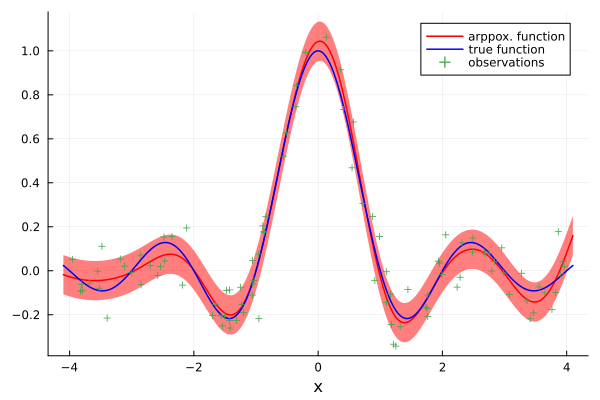

In [171]:
plot(xtest,predict_mean,ribbon = sqrt.(predict_var),
    label="arppox. function", lw=1.5,legend=:topright, color=:red1)
plot!(xtest,f_true,label="true function",lw=1.5, color=:blue2)
scatter!(xtrain,ytrain, label="observations",  alpha=1, ms=3.5, marker=:cross)
xlabel!("x")

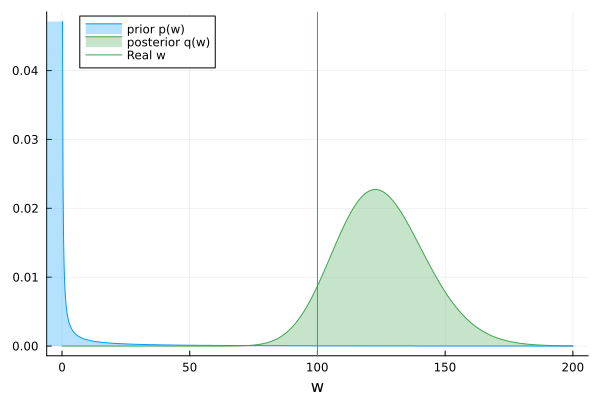

In [172]:
rw = range(0,200,length = 1000)


plot(rw, (x) -> pdf(GammaShapeRate(1e-2, 1e-2), x), fillalpha=0.3, fillrange = 0, label="prior p(w)", c=1,)
plot!(rw, (x) -> pdf(qw, x), fillalpha=0.3, fillrange = 0, label="posterior q(w)", c=3, legend_position=(0.15,0.95))

vline!([precision], label="Real w")
xlabel!("w")

## Test with classification

In [119]:
import StatsFuns: normcdf, normccdf, normlogcdf, normlogccdf, normlogpdf, normpdf, logsumexp

In [173]:
Random.seed!(145)
xmin, xmax = -5, 5  # Bounds of the data
N          = 100 # Number of samples
xtrain     = sort(rand(Uniform(xmin, xmax), N))
xtest      = collect(range(xmin, xmax; length=400));
kernelfunc =  2*with_lengthscale(SEKernel(),1.2)
meanfunc   = (x) -> 0.0;
grammatrix = kernelmatrix(kernelfunc,xtrain,xtrain) + 1e-6*diageye(N)
ytrain     = rand(MvNormal(zeros(length(xtrain)),grammatrix))
p          = normcdf.(ytrain)
ytrainbin  = map(rand,Bernoulli.(p));
ytrainbin = float(ytrainbin);

In [174]:
@model function gp_classification(y,x,Kuu)
    v ~ MvNormalMeanCovariance(zeros(size(Kuu,1)), Kuu)
    w ~ GammaShapeRate(0.01,0.01)
    θ ~ MvNormalMeanCovariance(zeros(2),50*diageye(2))
    for i in eachindex(y)
        z[i] ~ NewSGP(x[i],v,w,θ) 
        y[i] ~ Probit(z[i])
    end
end

In [175]:
Nu = 20; #number of inducing points
Xu = range(-5.,5.;length=Nu);
Kuu = kernelmatrix(kernel_gp([0., 0.]), Xu)
;

In [176]:
gp_constraints = @constraints begin
    q(z,v,w,θ) = q(z)q(v)q(w)q(θ)
    q(θ)::PointMassFormConstraint(starting_point = (args...) -> [log(1),log(1)])
end

@meta function meta_gp_classification(Xu,kernel)
    NewSGP() -> NewSGPMeta(Xu,nothing,kernel,nothing)
    Probit() -> ProbitMeta(32)
end

gp_initialization = @initialization begin
    q(v) = MvNormalMeanCovariance(zeros(size(Kuu,1)), Kuu)
    q(w) = GammaShapeRate(1e-2,1e-2)
    q(θ) = PointMass([0., 0.])
end
;

In [185]:
niter = 50

infer_result = infer(
    model = gp_classification(Kuu = Kuu,),
    iterations = niter,
    data = (y = ytrainbin, x = xtrain),
    constraints = gp_constraints,
    initialization = gp_initialization,
    meta = meta_gp_classification(Xu,kernel_gp),
    returnvars = (v = KeepLast(),w = KeepLast(),θ = KeepLast(),),
    free_energy = true,
    showprogress = false
)

Inference results:
  Posteriors       | available for (w, v, θ)
  Free Energy:     | Real[89.4187, 68.523, 70.5, 58.4694, 63.8851, 62.1503, 61.1988, 60.1681, 59.3491, 58.6648  …  51.4436, 51.3304, 51.2202, 51.113, 51.0087, 50.9071, 50.8082, 50.712, 50.6183, 50.5271]


In [193]:
qv = infer_result.posteriors[:v]
qw = infer_result.posteriors[:w]
qθ = infer_result.posteriors[:θ];

In [194]:
mean(qθ)

2-element Vector{Float64}:
 0.6687169109008336
 0.05328943951946404

In [195]:
function predict_new(x_test,qv,qw, qθ, meta)
    prediction_z = @call_rule NewSGP(:out, Marginalisation) (q_in=PointMass(x_test),q_v = qv, q_w = qw,q_θ = qθ, meta=meta)
    prediction_y = @call_rule Probit(:out, Marginalisation) (m_in=prediction_z,meta=ProbitMeta(32))
    return prediction_z, prediction_y
end

predict_new (generic function with 1 method)

In [196]:
predict_mean =[]
predict_var =[]
predict_func=[]
predict_var_func=[]
for i=1:length(xtest)
    prediction_z, prediction_y = predict_new(xtest[i],qv,qw,qθ, NewSGPMeta(Xu,nothing,kernel_gp,nothing))
    append!(predict_func,mean(prediction_z))
    append!(predict_var_func,var(prediction_z)) 
    append!(predict_mean,mean(prediction_y))
    append!(predict_var,var(prediction_y)) 
end

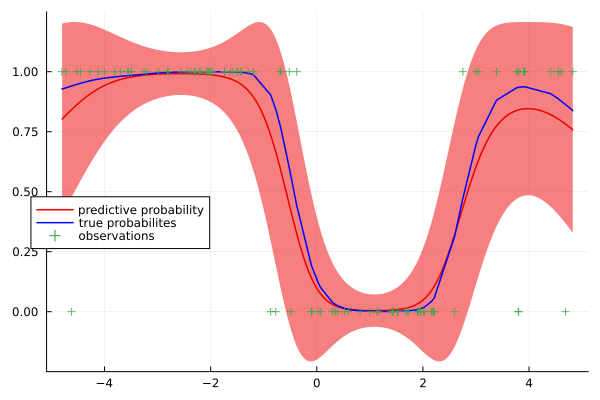

In [197]:
plot(xtest[9:393],predict_mean[9:393],ribbon = sqrt.(predict_var[9:393]),
    lw=1.5,label="predictive probability",color=:red2)
plot!(xtrain,p,linewidth=1.5,label="true probabilites",legend_position=(0.06,0.45),color=:blue)
scatter!(xtrain,ytrainbin,label="observations",marker=:cross)

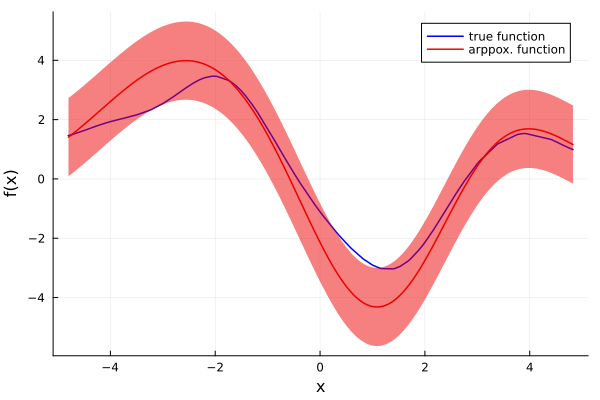

In [198]:
plot(xtrain,ytrain,label="true function",lw=1.5,color=:blue)
plot!(xtest[9:393],predict_func[9:393],ribbon = sqrt.(predict_var_func[9:393]),
     label="arppox. function",lw=1.5, legend=:topright, color=:red2)
xlabel!("x")
ylabel!("f(x)")

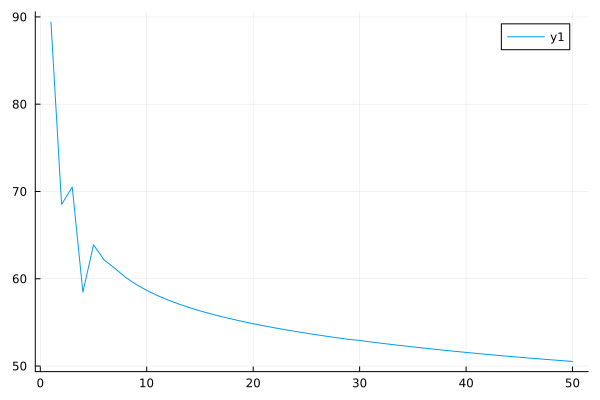

In [199]:
plot(infer_result.free_energy)